# 🧪 Virtual Screening with CADD

Welcome, CADDers!  
In this notebook, we will explore how to perform **virtual screening** using multiple drug-likeness and lead optimization criteria. The goal is to filter and prioritize compounds with favorable pharmacokinetic and chemical properties for drug development.

## 🔍 Screening Criteria

We will evaluate compounds using the following key filters:

- **Lipinski's Rule of Five** — To assess oral bioavailability.
- **Quantitative Estimate of Drug-Likeness (QED)** — A score that combines multiple properties into a single drug-likeness metric.
- **Synthetic Accessibility Score (SAscore)** — To estimate the ease of chemical synthesis.
- **PAINS (Pan Assay Interference Compounds)** — To flag problematic substructures that may lead to false positives in screening assays.
- **Tanimoto Similarity** — To measure molecular similarity (e.g., with known active compounds) based on fingerprints.

Let's begin by preparing the necessary tools and datasets.

Assignment 
1. ROV = 0
2. QED = >= 0.67
3. SAScore = <=4
4. PAINS
5. Tanimoto: ref Smiles = "C1=CC2=C(C=CC(=C2))N=C1", 0.3


In [107]:
import pandas as pd
import rdkit 
from rdkit import Chem

In [109]:
df = pd.read_csv("sampled_malaria.csv")


In [110]:
df

,SMILES,NLL
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03
...,...,...
2879,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42
2880,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61
2881,N#Cc1ccc(Oc2cccc(NC(=O)Nc3cccc(Cl)c3)c2)cc1Cl,24.55
2882,COc1cc(Cc2c(N)nc(N)nc2OC)ccc1OCc1ccccc1,10.68


In [111]:
df

,SMILES,NLL
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03
...,...,...
2879,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42
2880,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61
2881,N#Cc1ccc(Oc2cccc(NC(=O)Nc3cccc(Cl)c3)c2)cc1Cl,24.55
2882,COc1cc(Cc2c(N)nc(N)nc2OC)ccc1OCc1ccccc1,10.68


In [112]:
df.isna().sum()

SMILES    0
NLL       0
dtype: int64

## 💊 Lipinski's Rule of Five

Lipinski's Rule of Five is a widely used guideline in drug discovery to evaluate the **oral bioavailability** of a compound. It helps identify molecules that are more likely to become orally active drugs in humans.

A compound is considered likely to have good oral bioavailability if **no more than one** of the following rules is violated:

- 🔹 **Molecular weight** ≤ 500 Da  
- 🔹 **LogP** (octanol-water partition coefficient) ≤ 5  
- 🔹 **Hydrogen bond donors** (OH and NH groups) ≤ 5  
- 🔹 **Hydrogen bond acceptors** (N and O atoms) ≤ 10  

These rules are not absolute but serve as a **filter to prioritize drug-like molecules** during virtual screening.

> 📌 Note: Compounds that violate multiple rules may still be biologically active but are less likely to be orally bioavailable.



In [113]:
df

,SMILES,NLL
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03
...,...,...
2879,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42
2880,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61
2881,N#Cc1ccc(Oc2cccc(NC(=O)Nc3cccc(Cl)c3)c2)cc1Cl,24.55
2882,COc1cc(Cc2c(N)nc(N)nc2OC)ccc1OCc1ccccc1,10.68


In [115]:
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

In [116]:
df

,SMILES,NLL,Mol
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
...,...,...,...
2879,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...
2880,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...
2881,N#Cc1ccc(Oc2cccc(NC(=O)Nc3cccc(Cl)c3)c2)cc1Cl,24.55,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...
2882,COc1cc(Cc2c(N)nc(N)nc2OC)ccc1OCc1ccccc1,10.68,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...


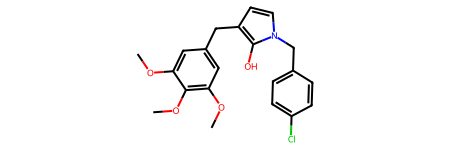

In [117]:
df['Mol'][11]

In [118]:
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors import rdMolDescriptors



In [119]:
df.isna().sum()

SMILES    0
NLL       0
Mol       0
dtype: int64

In [120]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

In [121]:
df

,SMILES,NLL,Mol
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...
...,...,...,...
2879,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...
2880,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...
2881,N#Cc1ccc(Oc2cccc(NC(=O)Nc3cccc(Cl)c3)c2)cc1Cl,24.55,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...
2882,COc1cc(Cc2c(N)nc(N)nc2OC)ccc1OCc1ccccc1,10.68,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...


In [122]:
df['MolWt'] = df['Mol'].apply(Descriptors.MolWt)

In [123]:
df

,SMILES,NLL,Mol,MolWt
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,321.856
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,396.447
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395
...,...,...,...,...
2879,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,424.545
2880,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,322.496
2881,N#Cc1ccc(Oc2cccc(NC(=O)Nc3cccc(Cl)c3)c2)cc1Cl,24.55,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,398.249
2882,COc1cc(Cc2c(N)nc(N)nc2OC)ccc1OCc1ccccc1,10.68,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,366.421


In [124]:
df['LogP'] = df['Mol'].apply(Descriptors.MolLogP)

In [125]:
df['HbondDonors'] = df['Mol'].apply(Descriptors.NumHDonors)

In [126]:
df['HbondAcceptors'] = df['Mol'].apply(Descriptors.NumHAcceptors)

In [127]:
df

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,321.856,3.47600,2,5
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,396.447,2.83660,2,8
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6
...,...,...,...,...,...,...,...
2879,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,424.545,4.12202,4,3
2880,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,322.496,4.26790,2,2
2881,N#Cc1ccc(Oc2cccc(NC(=O)Nc3cccc(Cl)c3)c2)cc1Cl,24.55,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,398.249,6.30138,2,3
2882,COc1cc(Cc2c(N)nc(N)nc2OC)ccc1OCc1ccccc1,10.68,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,366.421,2.82800,2,7


In [128]:
df_filtered = df[
    (df['MolWt'] <= 500) &
    #(df['MolWt'] >= 200) &
    (df['LogP'] <= 5) &
    (df['HbondDonors'] <= 5) &
    (df['HbondAcceptors'] <= 10)
].copy()


In [129]:
df_filtered.reset_index(inplace=True, drop=True)

In [130]:
df_filtered

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,321.856,3.47600,2,5
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,396.447,2.83660,2,8
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6
...,...,...,...,...,...,...,...
2115,Cc1ccc(CCNS(=O)(=O)c2ccc3c(c2)OCC(=O)N3)cc1,16.65,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,346.408,1.84692,2,4
2116,CNCCc1ccc(OCCCCOc2ccccc2CCC(=O)O)c(N)c1,17.61,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,386.492,3.28590,3,5
2117,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,424.545,4.12202,4,3
2118,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,322.496,4.26790,2,2


<Axes: >

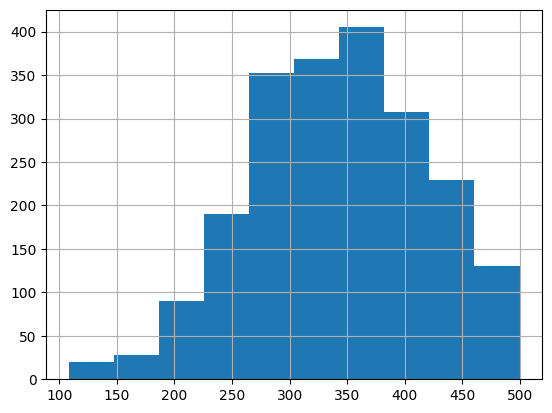

In [131]:
df_filtered['MolWt'].hist()

## ⚖️ QED (Quantitative Estimate of Drug-likeness)

QED is a metric that quantifies how "drug-like" a molecule is, based on a combination of several important physicochemical properties. It outputs a **single score between 0 and 1**, where **higher values indicate better drug-likeness** [(Bickerton et al., 2022)](https://pmc.ncbi.nlm.nih.gov/articles/PMC3524573/#:~:text=To%20quantify%20compound%20quality%20we,one%20(all%20properties%20favourable).).

### 🧬 Properties Considered in QED
QED combines the following molecular features:

- Molecular weight (MW)
- LogP (lipophilicity)
- Hydrogen bond donors (HBD)
- Hydrogen bond acceptors (HBA)
- Rotatable bonds
- Aromatic ring count
- Structural alerts
- Topological polar surface area (TPSA)

### QED values can range between zero (all properties unfavourable) and one (all properties favourable).

### 📊 QED Score Range and Interpretation

| QED Score | Interpretation             |
|-----------|----------------------------|
| 0.9 – 1.0 | **Highly drug-like**       |
| 0.7 – 0.9 | **Moderately drug-like**   |
| 0.4 – 0.7 | **Potentially drug-like**  |
| < 0.4     | **Poor drug-likeness**     |

Most marketed oral drugs tend to have QED scores **above 0.67**, but this is not a strict cutoff.

> 📌 QED is especially useful for ranking and prioritizing compounds during virtual screening campaigns, as it provides a better view of drug-likeness rather than binary filtering.


In [132]:
df

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,321.856,3.47600,2,5
3,COc1cc(COc2ccc(Cc3cnc(N)nc3N)cc2)cc(OC)c1OC,4.90,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,396.447,2.83660,2,8
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6
...,...,...,...,...,...,...,...
2879,CCCCCCC(NC(=O)Cc1ccc(NC(=O)Nc2ccccc2C)cc1)C(N)=O,24.42,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,424.545,4.12202,4,3
2880,c1ccc(CCNCCNC2(c3ccccc3)CCCCC2)cc1,19.61,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,322.496,4.26790,2,2
2881,N#Cc1ccc(Oc2cccc(NC(=O)Nc3cccc(Cl)c3)c2)cc1Cl,24.55,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,398.249,6.30138,2,3
2882,COc1cc(Cc2c(N)nc(N)nc2OC)ccc1OCc1ccccc1,10.68,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,366.421,2.82800,2,7


In [133]:
df['Qed'] = df['Mol'].apply(Descriptors.qed)

<Axes: >

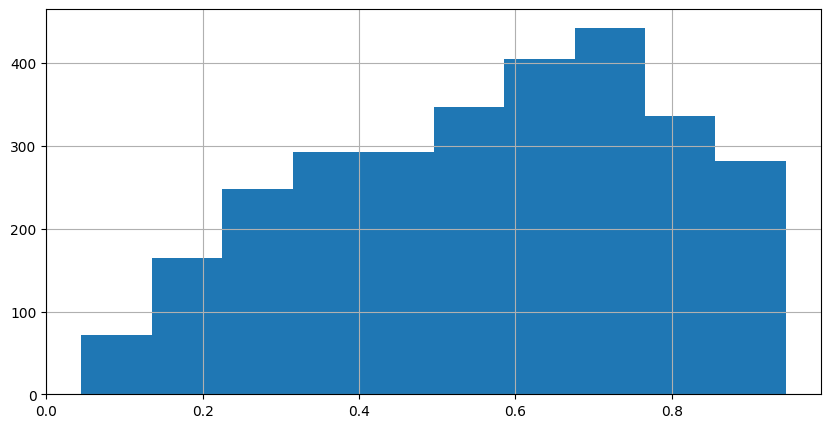

In [134]:
df['Qed'].hist(figsize=(10, 5))

In [135]:
df_filtered_qed =  df[df['Qed'] >= 0.67]

In [136]:
df_filtered_qed

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,321.856,3.47600,2,5,0.754418
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362
5,CCCC1(C)N=C(N)N=C(N)N1c1cccc(Cl)c1,5.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,279.775,2.30570,2,5,0.890843
...,...,...,...,...,...,...,...,...
2867,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784
2869,COCCNC(c1cccc(OC)c1)c1ccc(OC)c(OC)c1,22.25,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,331.412,3.03780,1,5,0.715856
2875,COc1ccc(Nc2ccc3nc(N)nc(N)c3c2)cc1,17.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,281.319,2.54640,3,6,0.681988
2876,Cc1ccc(CCNS(=O)(=O)c2ccc3c(c2)OCC(=O)N3)cc1,16.65,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,346.408,1.84692,2,4,0.865215


## 🛠️ Synthetic Accessibility (SA) Score

The **Synthetic Accessibility (SA) Score** estimates how easy or difficult it would be to **chemically synthesize a compound** in the laboratory. It is a useful metric in drug discovery, especially after virtual screening, to prioritize molecules that are not only active but also practical to make.

### 🔬 How It Works
The SA score combines two key components:
1. **Fragment contributions** — How common or rare the molecular fragments are based on a large dataset of known synthetic compounds.
2. **Complexity penalties** — Structural features that increase synthetic difficulty, such as:
   - Large ring systems
   - Highly branched structures
   - Chiral centers
   - Unusual functional groups

### 📊 SA Score Range and Interpretation

| SA Score | Interpretation              |
|----------|-----------------------------|
| 1.0 – 3.0 | **Easy to synthesize**      |
| 3.1 – 5.0 | **Moderate difficulty**     |
| 5.1 – 10.0| **Difficult to synthesize** |

> ✅ Lower SA scores are more desirable when selecting compounds for further development, as they indicate a higher likelihood of successful synthesis.

### 🧪 Why It Matters
Even the most promising compound in terms of activity and drug-likeness may not be useful if it can't be synthesized efficiently. SA score helps avoid such dead ends early in the pipeline.


In [137]:
from rdkit.Contrib.SA_Score import sascorer

In [138]:
df_filtered_qed['sascore'] = df_filtered_qed['Mol'].apply(sascorer.calculateScore)

C:\Users\DELL\AppData\Local\Temp\ipykernel_8608\3599187673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_qed['sascore'] = df_filtered_qed['Mol'].apply(sascorer.calculateScore)


In [139]:
df_filtered_qed

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed,sascore
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137,2.204285
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138,2.777818
2,CCCCCCCC1N=C(N)N=C(N)N1c1cccc(Cl)c1,4.86,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,321.856,3.47600,2,5,0.754418,3.185959
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,2.042819
5,CCCC1(C)N=C(N)N=C(N)N1c1cccc(Cl)c1,5.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,279.775,2.30570,2,5,0.890843,3.330429
...,...,...,...,...,...,...,...,...,...
2867,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784,2.095506
2869,COCCNC(c1cccc(OC)c1)c1ccc(OC)c(OC)c1,22.25,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,331.412,3.03780,1,5,0.715856,2.388460
2875,COc1ccc(Nc2ccc3nc(N)nc(N)c3c2)cc1,17.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,281.319,2.54640,3,6,0.681988,1.959807
2876,Cc1ccc(CCNS(=O)(=O)c2ccc3c(c2)OCC(=O)N3)cc1,16.65,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,346.408,1.84692,2,4,0.865215,2.136286


<Axes: >

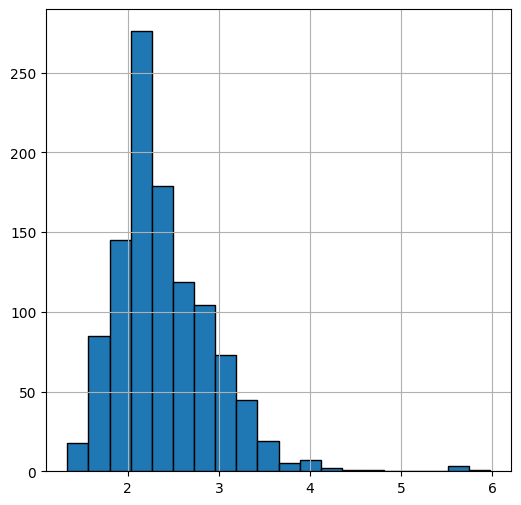

In [140]:
df_filtered_qed['sascore'].hist(bins=20, figsize=(6,6), edgecolor='black')

In [141]:
df_filtered_qed_sascore = df_filtered_qed[df_filtered_qed['sascore'] <= 3.0]

In [142]:
df_filtered_qed_sascore

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed,sascore
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137,2.204285
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138,2.777818
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,2.042819
8,Cc1cc(Oc2ccccc2N)cc(C(=O)O)c1N,21.89,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,258.277,2.64992,3,4,0.734912,2.077624
9,COc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,8.76,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,2.034192
...,...,...,...,...,...,...,...,...,...
2867,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784,2.095506
2869,COCCNC(c1cccc(OC)c1)c1ccc(OC)c(OC)c1,22.25,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,331.412,3.03780,1,5,0.715856,2.388460
2875,COc1ccc(Nc2ccc3nc(N)nc(N)c3c2)cc1,17.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,281.319,2.54640,3,6,0.681988,1.959807
2876,Cc1ccc(CCNS(=O)(=O)c2ccc3c(c2)OCC(=O)N3)cc1,16.65,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,346.408,1.84692,2,4,0.865215,2.136286


## 🚫 PAINS (Pan Assay Interference Compounds)

**PAINS** are **Pan Assay Interference Compounds**—molecules that tend to give **false positive results** in biological assays. These compounds interfere with multiple assay types, not through specific biological activity, but through non-specific or reactive mechanisms.

### ⚠️ Why PAINS Are Problematic

- They may appear as "hits" in virtual screening or high-throughput screening campaigns.
- They often interfere with assay readouts due to:
  - Redox cycling
  - Covalent modification of proteins
  - Aggregation
  - Fluorescence interference

Because of this, they can **mislead drug discovery efforts** by diverting time and resources toward compounds with no true pharmacological potential.

### 🔬 How Are PAINS Identified?

PAINS filters use a set of predefined **substructure patterns** (SMARTS) to flag known problematic motifs. These filters were originally developed by Baell and Holloway (2010) after analyzing common assay artifacts.

### 🧪 In Practice

Before advancing any compound, it's good practice to **screen for PAINS** using computational filters (e.g., using RDKit or other cheminformatics tools) and **remove or deprioritize** flagged molecules.

> ✅ Removing PAINS helps improve the quality and reliability of your virtual screening pipeline.



In [143]:
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import *
from rdkit.Chem import Descriptors, Draw, PandasTools

In [144]:
df_filtered_qed_sascore

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed,sascore
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137,2.204285
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138,2.777818
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,2.042819
8,Cc1cc(Oc2ccccc2N)cc(C(=O)O)c1N,21.89,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,258.277,2.64992,3,4,0.734912,2.077624
9,COc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,8.76,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,2.034192
...,...,...,...,...,...,...,...,...,...
2867,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784,2.095506
2869,COCCNC(c1cccc(OC)c1)c1ccc(OC)c(OC)c1,22.25,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,331.412,3.03780,1,5,0.715856,2.388460
2875,COc1ccc(Nc2ccc3nc(N)nc(N)c3c2)cc1,17.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,281.319,2.54640,3,6,0.681988,1.959807
2876,Cc1ccc(CCNS(=O)(=O)c2ccc3c(c2)OCC(=O)N3)cc1,16.65,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,346.408,1.84692,2,4,0.865215,2.136286


In [145]:
#filter by pains
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [146]:
substructures = pd.read_csv("pains_list_1.csv", sep="\s+")  
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))

Number of unwanted substructures in collection: 104


In [149]:
substructures


,name,smarts,rdkit_molecule
0,>2EsterGroups,"C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]",<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...
1,2-haloPyridine,"n1c([F,Cl,Br,I])cccc1",<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...
2,acidHalide,"C(=O)[Cl,Br,I,F]",<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...
3,acyclic-C=C-O,C=[C!r]O,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...
4,acylCyanide,N#CC(=O),<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...
...,...,...,...
99,thiol,[SH],<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...
100,Three-membered-heterocycle,"*1[O,S,N]*1",<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...
101,triflate,OS(=O)(=O)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...
102,triphenyl-methylsilyl,"[SiR0,CR0](c1ccccc1)(c2ccccc2)(c3ccccc3)",<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...


In [151]:
from tqdm import tqdm

# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(df_filtered_qed_sascore.iterrows(), total=df_filtered_qed_sascore.shape[0]):
    molecule = Chem.MolFromSmiles(row.SMILES)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "smiles": row.SMILES,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
df_clean = df.loc[clean]




100%|██████████| 947/947 [00:16<00:00, 58.01it/s]


In [152]:
df_clean

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362
9,COc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,8.76,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362
14,NC1=NC(c2ccccc2)N(c2cccc(Cl)c2)C(N)=N1,5.46,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,299.765,2.48820,2,5,0.893777
...,...,...,...,...,...,...,...,...
2836,CCc1ccccc1NC(=O)c1ccccc1Cc1ccccc1,18.49,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,315.416,5.09210,1,1,0.697682
2837,Nc1nc(N)c(-c2ccc(Cl)cc2)cc1-c1ccc(Cl)cc1,19.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,330.218,4.88680,2,3,0.703178
2867,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784
2875,COc1ccc(Nc2ccc3nc(N)nc(N)c3c2)cc1,17.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,281.319,2.54640,3,6,0.681988


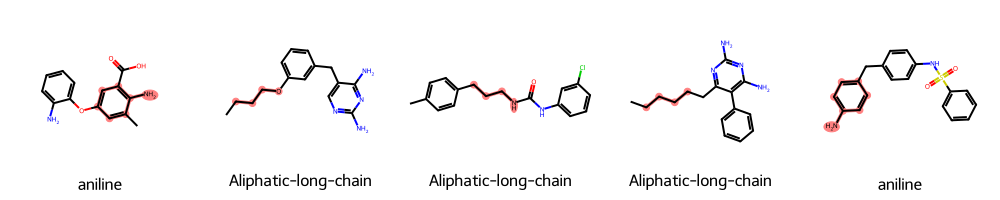

In [153]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(5).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(5).rdkit_molecule), molsPerRow=5,
    highlightAtomLists=to_highlight,
    legends=list(matches.head(5).substructure_name),
)



In [154]:
df_clean

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362
9,COc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,8.76,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362
14,NC1=NC(c2ccccc2)N(c2cccc(Cl)c2)C(N)=N1,5.46,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,299.765,2.48820,2,5,0.893777
...,...,...,...,...,...,...,...,...
2836,CCc1ccccc1NC(=O)c1ccccc1Cc1ccccc1,18.49,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,315.416,5.09210,1,1,0.697682
2837,Nc1nc(N)c(-c2ccc(Cl)cc2)cc1-c1ccc(Cl)cc1,19.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,330.218,4.88680,2,3,0.703178
2867,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784
2875,COc1ccc(Nc2ccc3nc(N)nc(N)c3c2)cc1,17.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,281.319,2.54640,3,6,0.681988


In [155]:
matches

,smiles,rdkit_molecule,substructure,substructure_name
0,Cc1cc(Oc2ccccc2N)cc(C(=O)O)c1N,<rdkit.Chem.rdchem.Mol object at 0x000002C1FBF...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,aniline
1,CCCCOc1cccc(Cc2cnc(N)nc2N)c1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain
2,Cc1ccc(CCCNC(=O)Nc2cccc(Cl)c2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain
3,CCCCCCc1nc(N)nc(N)c1-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain
4,Nc1ccc(Cc2ccc(NS(=O)(=O)c3ccccc3)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,aniline
...,...,...,...,...
189,CCCCNC(=O)c1ccc2c(c1)C(=O)c1ccccc1-2,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC1...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain
190,CCc1ccc(CNC(=O)c2ccc([N+](=O)[O-])cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC1...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,nitro-group
191,CCc1ccc(CNC(=O)c2ccc([N+](=O)[O-])cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC1...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Oxygen-nitrogen-single-bond
192,COCCNC(c1cccc(OC)c1)c1ccc(OC)c(OC)c1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC1...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain


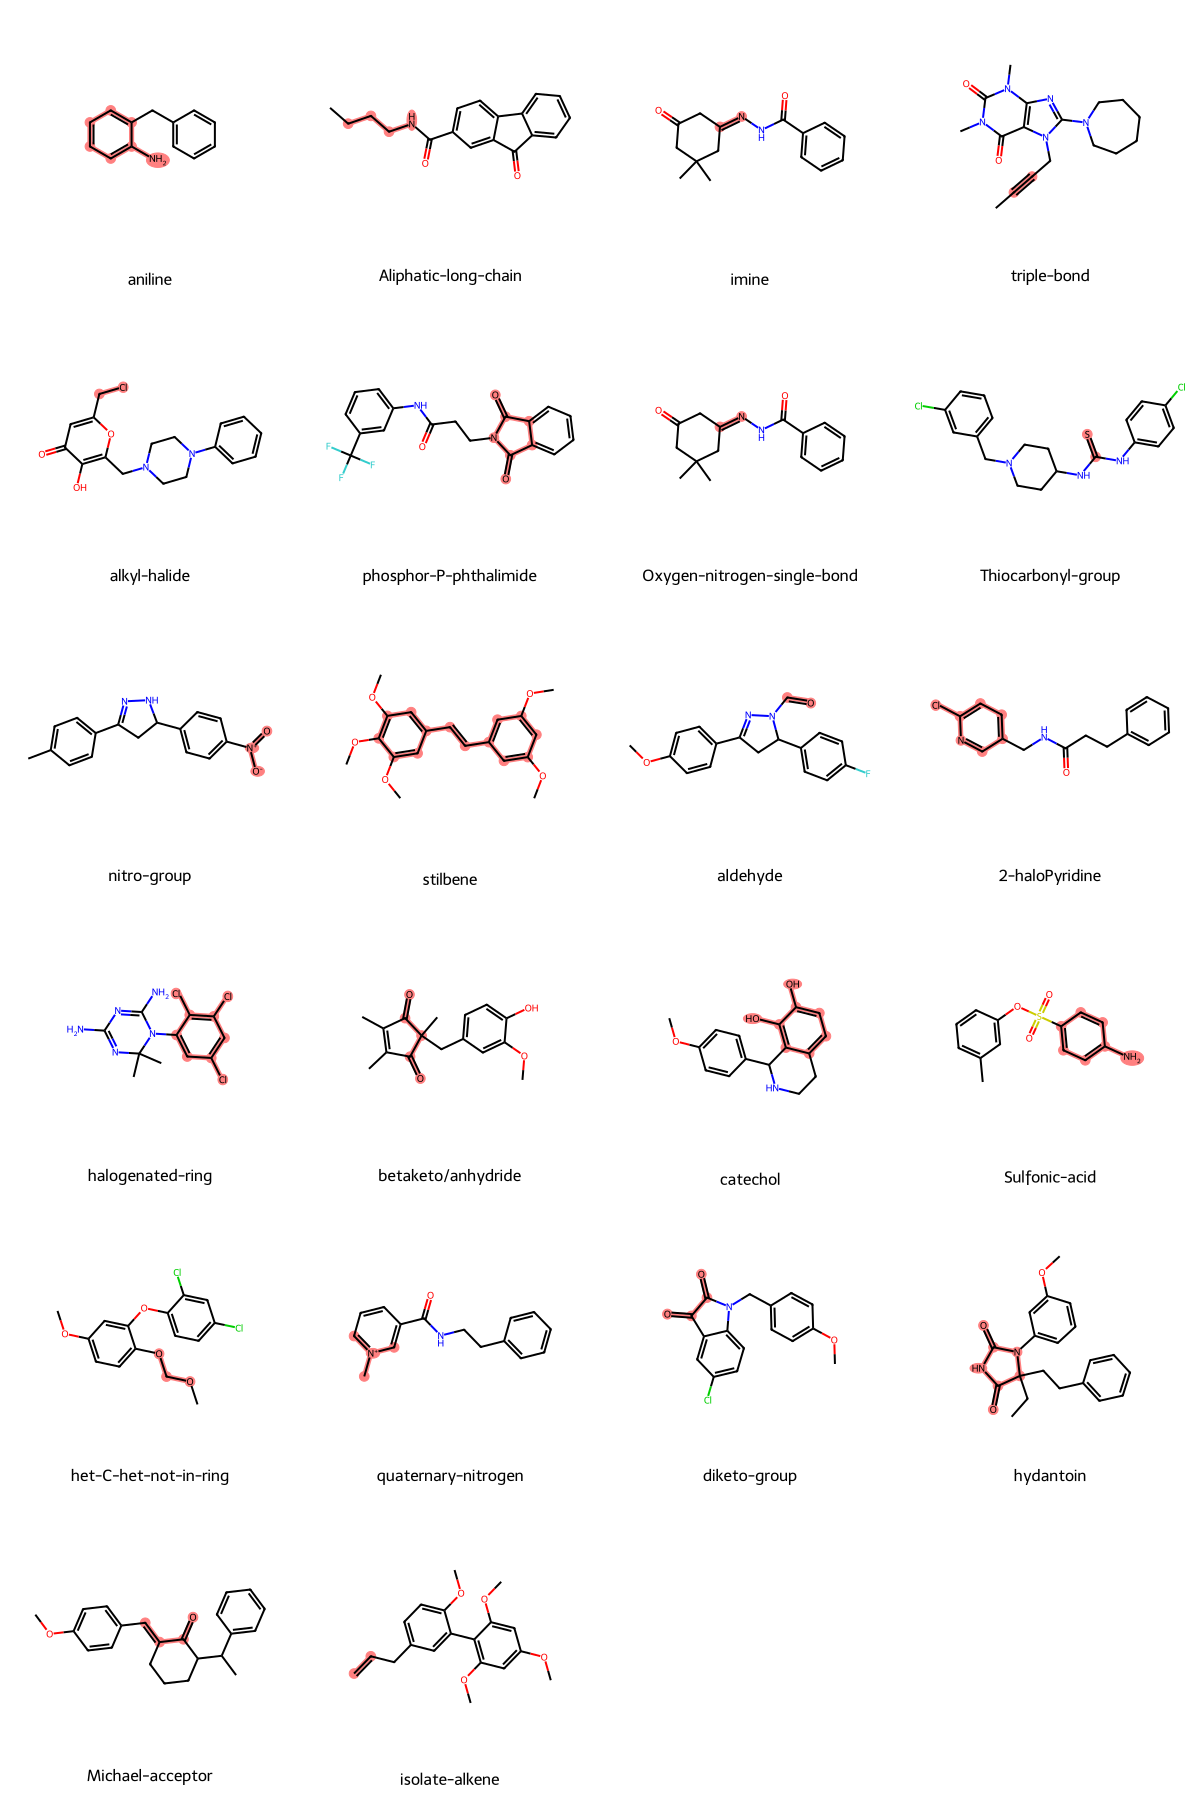

In [157]:

from rdkit.Chem import Draw
from collections import defaultdict
import random

pains_groups = defaultdict(list)

for idx, row in matches.iterrows():
    substructure_name = row['substructure_name']
    smiles = row['smiles']
    pains_groups[substructure_name].append(smiles)

# Step 2: Randomly select one molecule from each PAINS substructure group
selected_smiles = {group: random.choice(smiles_list) for group, smiles_list in pains_groups.items()}

# Step 3: Prepare molecules and highlight PAINS substructures
mols = []
highlight_atoms = []
legends = []

# Iterate through each selected molecule for a PAINS substructure
for pains_group, smiles in selected_smiles.items():
    mol = Chem.MolFromSmiles(smiles)
    mols.append(mol)
    
    # Get substructure match for PAINS
    substructure = matches[matches['smiles'] == smiles]['substructure'].values[0]
    match = mol.GetSubstructMatch(substructure)
    
    # Highlight the atoms in the substructure match
    if match:
        highlight_atoms.append(list(match))
    else:
        highlight_atoms.append([])  # If no match found, append empty list
    
    legends.append(f'{pains_group}')  # Add the group name to the legend

# Step 4: Draw molecules with highlighted PAINS substructures
img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=4,  # 4 molecules per row
    subImgSize=(300, 300),  # Size of each subimage
    highlightAtomLists=highlight_atoms,  # Highlight PAINS substructures
    legends=legends  # Labels for the PAINS groups
)

# Step 5: Display the image
img

In [158]:
matches.drop_duplicates(subset='smiles', inplace=True)

In [159]:
matches

,smiles,rdkit_molecule,substructure,substructure_name
0,Cc1cc(Oc2ccccc2N)cc(C(=O)O)c1N,<rdkit.Chem.rdchem.Mol object at 0x000002C1FBF...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,aniline
1,CCCCOc1cccc(Cc2cnc(N)nc2N)c1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain
2,Cc1ccc(CCCNC(=O)Nc2cccc(Cl)c2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain
3,CCCCCCc1nc(N)nc(N)c1-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain
4,Nc1ccc(Cc2ccc(NS(=O)(=O)c3ccccc3)cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,aniline
...,...,...,...,...
188,O=c1c(NCCc2cccc(F)c2)c(Nc2ccc(Cl)cc2)c1=O,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC1...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,diketo-group
189,CCCCNC(=O)c1ccc2c(c1)C(=O)c1ccccc1-2,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC1...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain
190,CCc1ccc(CNC(=O)c2ccc([N+](=O)[O-])cc2)cc1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC1...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,nitro-group
192,COCCNC(c1cccc(OC)c1)c1ccc(OC)c(OC)c1,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC1...,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC0...,Aliphatic-long-chain


In [160]:
df_clean

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362
9,COc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,8.76,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362
14,NC1=NC(c2ccccc2)N(c2cccc(Cl)c2)C(N)=N1,5.46,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,299.765,2.48820,2,5,0.893777
...,...,...,...,...,...,...,...,...
2836,CCc1ccccc1NC(=O)c1ccccc1Cc1ccccc1,18.49,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,315.416,5.09210,1,1,0.697682
2837,Nc1nc(N)c(-c2ccc(Cl)cc2)cc1-c1ccc(Cl)cc1,19.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,330.218,4.88680,2,3,0.703178
2867,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784
2875,COc1ccc(Nc2ccc3nc(N)nc(N)c3c2)cc1,17.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,281.319,2.54640,3,6,0.681988


## 🤝 Tanimoto Similarity

**Tanimoto Similarity** is a widely used metric in cheminformatics to compare the **structural similarity** between two molecules, typically using their **molecular fingerprints** (such as ECFP).

### 🧪 What It Measures

Tanimoto similarity quantifies how many structural features two molecules share:

$$
\text{Tanimoto Similarity} = \frac{c}{a + b - c}
$$

Where:  
- \( a \): Number of bits set to 1 in fingerprint A  
- \( b \): Number of bits set to 1 in fingerprint B  
- \( c \): Number of bits set to 1 in both A and B (the intersection)

### 📊 Similarity Score Range

| Tanimoto Score | Interpretation         |
|----------------|------------------------|
| 1.0            | Identical structures    |
| 0.7 – 0.99     | Highly similar          |
| 0.4 – 0.7      | Moderately similar      |
| < 0.4          | Weak or no similarity   |

### 🔍 Why It’s Useful

Tanimoto similarity is commonly used for:
- **Similarity-based virtual screening**
- Identifying analogs of known active compounds
- **Clustering** compounds by structure

> ✅ Molecules with a Tanimoto score above **0.7** to a known active are often prioritized in drug discovery.


In [161]:
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs
tqdm.pandas()

df_clean['Fingerprint'] = df_clean['Mol'].apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024))


ref_smiles = 'CN(CC1=CN=C2C(=N1)C(=NC(=N2)N)N)C3=CC=C(C=C3)C(=O)N[C@@H](CCC(=O)O)C(=O)O'  

ref_mol = Chem.MolFromSmiles(ref_smiles)
ref_fp = AllChem.GetMorganFingerprintAsBitVect(ref_mol, radius=2, nBits=1024)


df_clean['Tanimoto'] = df_clean['Fingerprint'].progress_apply(lambda fp: DataStructs.TanimotoSimilarity(ref_fp, fp))


df_clean= df_clean[df_clean['Tanimoto'] >= 0.1].copy()

df_clean

[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerator
[19:34:11] DEPRECATION WARNING: please use MorganGenerat

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed,Fingerprint,Tanimoto
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.200000
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.101124
4,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.176471
9,COc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,8.76,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.190476
14,NC1=NC(c2ccccc2)N(c2cccc(Cl)c2)C(N)=N1,5.46,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,299.765,2.48820,2,5,0.893777,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.119048
...,...,...,...,...,...,...,...,...,...,...
2830,Cc1cc(Cc2c(C)nc(N)nc2N)ccc1F,16.25,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,246.289,1.98774,2,4,0.849006,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.200000
2836,CCc1ccccc1NC(=O)c1ccccc1Cc1ccccc1,18.49,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,315.416,5.09210,1,1,0.697682,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.139241
2837,Nc1nc(N)c(-c2ccc(Cl)cc2)cc1-c1ccc(Cl)cc1,19.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,330.218,4.88680,2,3,0.703178,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.128571
2867,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.197368


In [162]:
df_clean.reset_index(inplace=True, drop=True)

In [163]:
df_clean

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed,Fingerprint,Tanimoto
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.200000
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.101124
2,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.176471
3,COc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,8.76,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.190476
4,NC1=NC(c2ccccc2)N(c2cccc(Cl)c2)C(N)=N1,5.46,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,299.765,2.48820,2,5,0.893777,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.119048
...,...,...,...,...,...,...,...,...,...,...
654,Cc1cc(Cc2c(C)nc(N)nc2N)ccc1F,16.25,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,246.289,1.98774,2,4,0.849006,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.200000
655,CCc1ccccc1NC(=O)c1ccccc1Cc1ccccc1,18.49,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,315.416,5.09210,1,1,0.697682,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.139241
656,Nc1nc(N)c(-c2ccc(Cl)cc2)cc1-c1ccc(Cl)cc1,19.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,330.218,4.88680,2,3,0.703178,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.128571
657,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.197368


In [164]:
df_clean[df_clean['Tanimoto'] >= 0.3].shape

(3, 10)

In [165]:
df_clean

,SMILES,NLL,Mol,MolWt,LogP,HbondDonors,HbondAcceptors,Qed,Fingerprint,Tanimoto
0,CCc1nc(N)nc(N)c1-c1cccc(Cl)c1,4.85,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,248.717,2.52380,2,4,0.856137,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.200000
1,NC1=NC(c2ccc(Oc3ccccc3)cc2)N(c2ccc(Cl)cc2)C(N)=N1,4.75,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,391.862,4.28050,2,6,0.694138,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.101124
2,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,7.03,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.176471
3,COc1cc(Cc2cnc(N)nc2N)ccc1OCc1ccccc1,8.76,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,336.395,2.81940,2,6,0.718362,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.190476
4,NC1=NC(c2ccccc2)N(c2cccc(Cl)c2)C(N)=N1,5.46,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC6...,299.765,2.48820,2,5,0.893777,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.119048
...,...,...,...,...,...,...,...,...,...,...
654,Cc1cc(Cc2c(C)nc(N)nc2N)ccc1F,16.25,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,246.289,1.98774,2,4,0.849006,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.200000
655,CCc1ccccc1NC(=O)c1ccccc1Cc1ccccc1,18.49,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,315.416,5.09210,1,1,0.697682,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.139241
656,Nc1nc(N)c(-c2ccc(Cl)cc2)cc1-c1ccc(Cl)cc1,19.33,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,330.218,4.88680,2,3,0.703178,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.128571
657,Nc1nc(-c2cccc(Cl)c2)c(-c2cccc(Cl)c2)cc1C(=O)O,25.52,<rdkit.Chem.rdchem.Mol object at 0x000002C1FC7...,359.212,5.00280,2,3,0.689784,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.197368


In [168]:
print(top5.columns)


Index(['SMILES', 'NLL', 'Mol', 'MolWt', 'LogP', 'HbondDonors',
       'HbondAcceptors', 'Qed', 'Fingerprint', 'Tanimoto'],
      dtype='object')


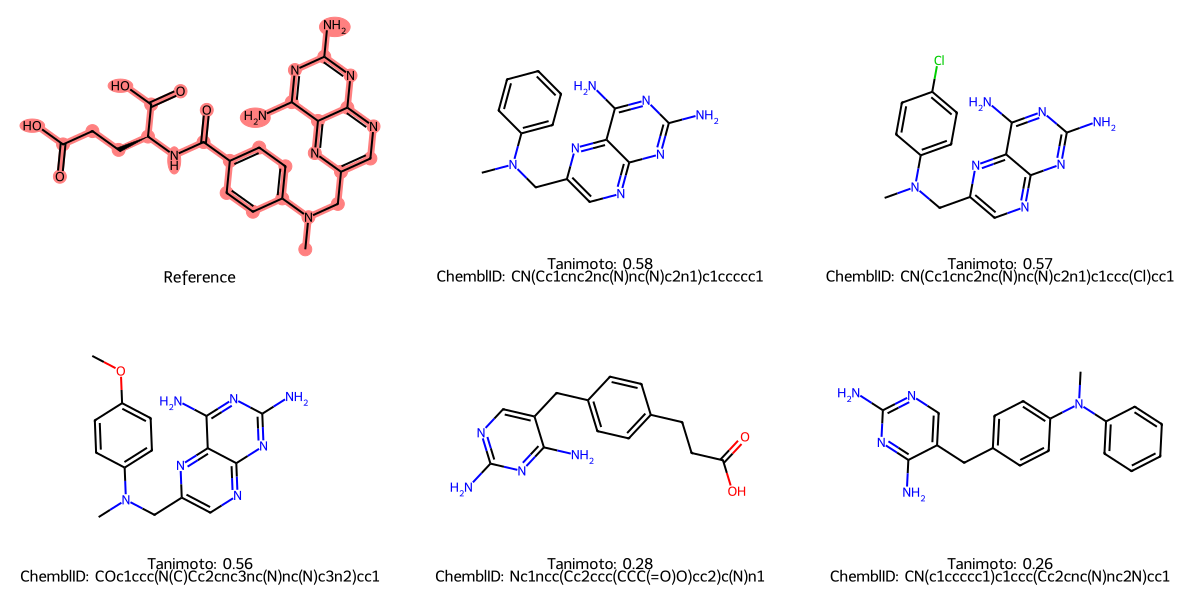

In [169]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D

# -----------------------------
# Filter top 5 by Tanimoto similarity
# -----------------------------
top5 = df_clean.sort_values(by='Tanimoto', ascending=False).head(5)

# -----------------------------
# Convert SMILES to Mol objects
# -----------------------------
top5_mols = [mol for mol in top5['Mol'] if mol is not None]

# -----------------------------
# Reference molecule
# -----------------------------
ref_mol = Chem.MolFromSmiles(ref_smiles)
AllChem.Compute2DCoords(ref_mol)

# -----------------------------
#  Generate 2D coordinates and align to reference
# -----------------------------
for mol in top5_mols:
    AllChem.Compute2DCoords(mol)
    try:
        AllChem.GenerateDepictionMatching2DStructure(mol, ref_mol)
    except ValueError:
        # Fallback: just use standard 2D coords
        pass

# ---------------------------
# Combine reference with top 5
# -----------------------------
mols_to_draw = [ref_mol] + top5_mols

# -----------------------------
# Create legends
# -----------------------------
legends = ['Reference'] + [
    f"Tanimoto: {sim:.2f}\nChemblID: {cid}" 
    for sim, cid in zip(top5['Tanimoto'], top5['SMILES'])
]

# -----------------------------
#  Highlight atoms matching reference (if possible)
# -----------------------------
highlight_atom_lists = []
for mol in mols_to_draw:
    if mol.HasSubstructMatch(ref_mol):
        match = mol.GetSubstructMatch(ref_mol)
    else:
        match = ()
    highlight_atom_lists.append(match)

# -----------------------------
#  Draw grid image
# -----------------------------
img = Draw.MolsToGridImage(
    mols_to_draw,
    molsPerRow=3,
    subImgSize=(400, 300),
    legends=legends,
    highlightAtomLists=highlight_atom_lists
)

# Display image
img


In [170]:
df_clean.to_csv("df_clean_malaria.csv")